In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from ucimlrepo import fetch_ucirepo

In [ ]:
from ucimlrepo import fetch_ucirepo

covertype = fetch_ucirepo(id=31)

In [11]:
x = covertype.data.features
y = covertype.data.targets

print("\ndataset overview:")
display(covertype.metadata)



dataset overview:


{'uci_id': 31,
 'name': 'Covertype',
 'repository_url': 'https://archive.ics.uci.edu/dataset/31/covertype',
 'data_url': 'https://archive.ics.uci.edu/static/public/31/data.csv',
 'abstract': 'Classification of pixels into 7 forest cover types based on attributes such as elevation, aspect, slope, hillshade, soil-type, and more.',
 'area': 'Biology',
 'tasks': ['Classification'],
 'characteristics': ['Multivariate'],
 'num_instances': 581012,
 'num_features': 54,
 'feature_types': ['Categorical', 'Integer'],
 'demographics': [],
 'target_col': ['Cover_Type'],
 'index_col': None,
 'has_missing_values': 'no',
 'missing_values_symbol': None,
 'year_of_dataset_creation': 1998,
 'last_updated': 'Sat Mar 16 2024',
 'dataset_doi': '10.24432/C50K5N',
 'creators': ['Jock Blackard'],
 'intro_paper': None,
 'additional_info': {'summary': 'Predicting forest cover type from cartographic variables only (no remotely sensed data).  The actual forest cover type for a given observation (30 x 30 meter cell

In [12]:
print("\n target distribution:")
print(y.value_counts())


 target distribution:
Cover_Type
2             283301
1             211840
3              35754
7              20510
6              17367
5               9493
4               2747
Name: count, dtype: int64


In [ ]:
from sklearn.preprocessing import StandardScaler

# Select continuous features
continuous_cols = x.columns[:10]
scaler = StandardScaler()
x[continuous_cols] = scaler.fit_transform(x[continuous_cols])

/tmp/ipykernel_76239/1886094695.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[continuous_cols] = scaler.fit_transform(x[continuous_cols])


In [ ]:
# Convert binary columns to integers
x.iloc[:, 10:] = x.iloc[:, 10:].astype(int)

In [15]:
y = y.values.ravel() - 1  # Adjust labels from 1-7 to 0-6


In [19]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(
    x, y, test_size=0.10, random_state=42, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)


# if we dont use strafity :
    - some classes may not be in the traning or validation 
    - bad acc on the test data

In [20]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

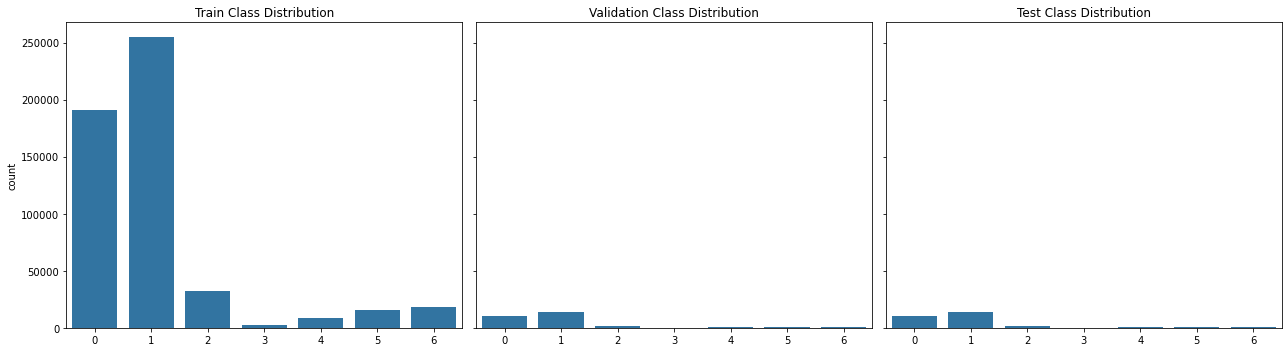

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
sns.countplot(x=y_train, ax=axs[0])
axs[0].set_title('Train Class Distribution')
sns.countplot(x=y_val, ax=axs[1])
axs[1].set_title('Validation Class Distribution')
sns.countplot(x=y_test, ax=axs[2])
axs[2].set_title('Test Class Distribution')
plt.tight_layout()
plt.show()

ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

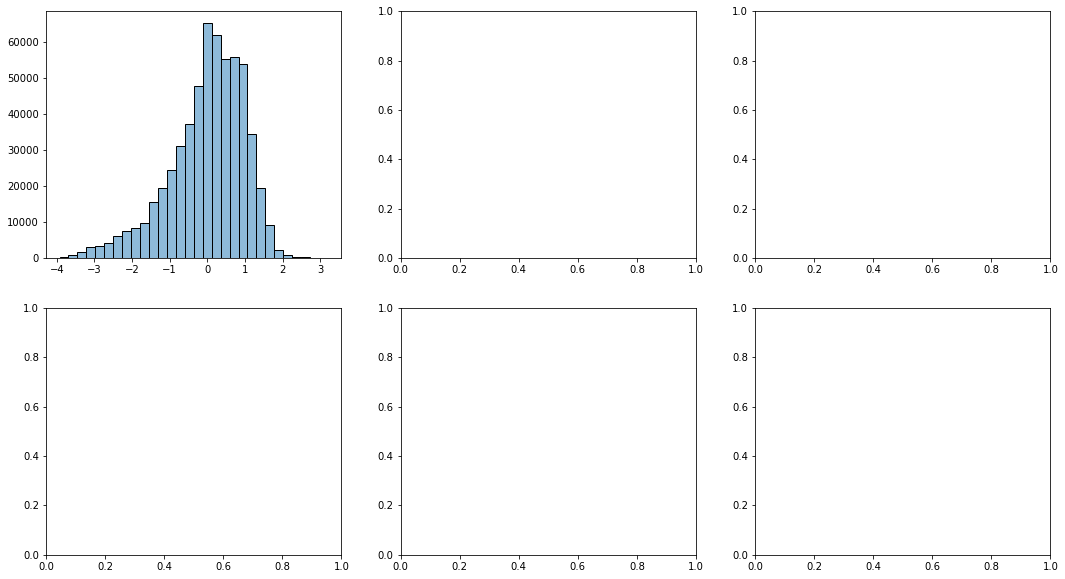

In [29]:
fig, axs = plt.subplots(2, 3, figsize=(18, 10))
selected_features = ['Elevation', 'Slope', 'Aspect', 'Hillshade_Noon', 'Horizontal_Distance_To_Roadways', 'Hillshade_3pm']
for ax, feature in zip(axs.flatten(), selected_features):
    sns.histplot(x[feature], bins=30, kde=True, ax=ax)
    ax.set_title(f'Histogram of {feature}')
plt.tight_layout()
plt.show()


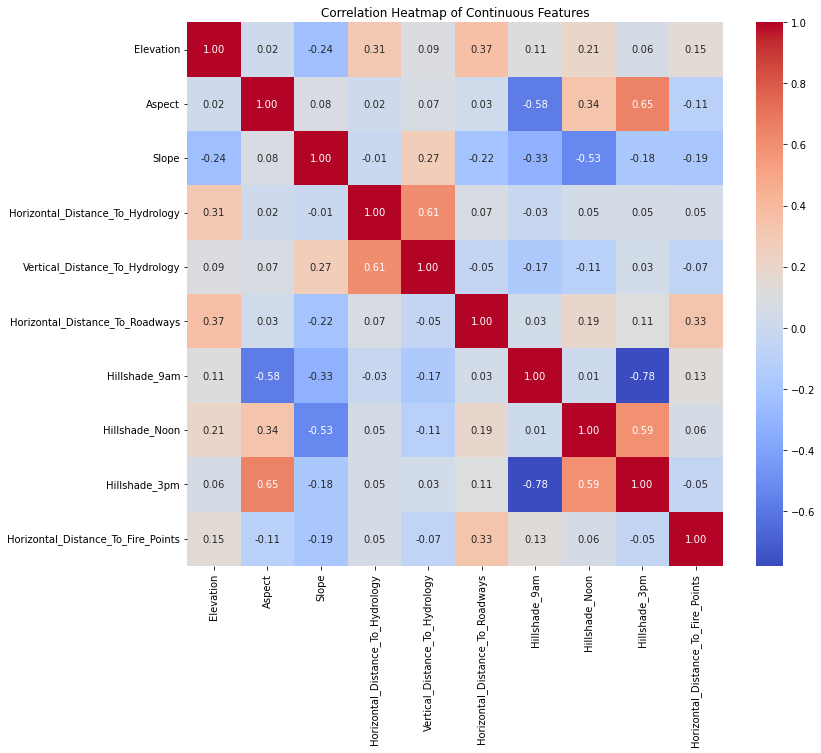

In [24]:
plt.figure(figsize=(12, 10))
corr = x[continuous_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Continuous Features")
plt.show()

In [ ]:
from torch.utils.data import Dataset, DataLoader

class TabularDataset(Dataset):
    def __init__(self, features, labels):
        # converting data to tensor
        self.X = torch.tensor(features.values, dtype=torch.float32)
        self.y = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [ ]:
train_dataset = TabularDataset(X_train, y_train)
val_dataset = TabularDataset(X_val, y_val)
test_dataset = TabularDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True) # shuffle true for the training data
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [33]:
# creating the model 

import torch
import torch.nn as nn
import torch.nn.functional as F

class FullyConnectedNet(nn.Module):
    def __init__(self, input_dim=54, hidden_dims=[128, 64], output_dim=7, dropout_p=0.5):
        super(FullyConnectedNet, self).__init__()
        # First layer
        self.fc1 = nn.Linear(input_dim, hidden_dims[0])
        self.dropout1 = nn.Dropout(p=dropout_p)
        self.bn1 = nn.BatchNorm1d(hidden_dims[0])
        # Second layer
        self.fc2 = nn.Linear(hidden_dims[0], hidden_dims[1])
        self.dropout2 = nn.Dropout(p=dropout_p)
        self.bn2 = nn.BatchNorm1d(hidden_dims[1])
        # Output layer
        self.fc_out = nn.Linear(hidden_dims[1], output_dim)

    def forward(self, x):
        # Layer 1
        x = self.fc1(x)
        x = self.dropout1(x)
        x = F.relu(x)
        x = self.bn1(x)
        # Layer 2
        x = self.fc2(x)
        x = self.dropout2(x)
        x = F.relu(x)
        x = self.bn2(x)
        # Output
        x = self.fc_out(x)
        return x

model = FullyConnectedNet(input_dim=54, hidden_dims=[128, 64], output_dim=7, dropout_p=0.5)

criterion = nn.CrossEntropyLoss()



In [35]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 20

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = FullyConnectedNet(input_dim=54, hidden_dims=[128, 64], output_dim=7, dropout_p=0.5)
model.to(device)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {total_loss / len(train_loader):.4f}")


    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            outputs = model(X_batch)
            val_loss += criterion(outputs, y_batch).item()
    print(f"Epoch {epoch}: train_loss={loss.item():.4f}, val_loss={val_loss/len(val_loader):.4f}")


Using device: cuda
Epoch 1/20, Train Loss: 2.0671
Epoch 0: train_loss=2.0841, val_loss=1.9922
Epoch 2/20, Train Loss: 2.0668
Epoch 1: train_loss=2.1814, val_loss=1.9934
Epoch 3/20, Train Loss: 2.0680
Epoch 2: train_loss=1.9628, val_loss=1.9845
Epoch 4/20, Train Loss: 2.0674
Epoch 3: train_loss=1.9161, val_loss=1.9879
Epoch 5/20, Train Loss: 2.0667
Epoch 4: train_loss=2.1084, val_loss=1.9895
Epoch 6/20, Train Loss: 2.0673
Epoch 5: train_loss=1.9943, val_loss=1.9936
Epoch 7/20, Train Loss: 2.0667
Epoch 6: train_loss=1.8734, val_loss=1.9778
Epoch 8/20, Train Loss: 2.0660
Epoch 7: train_loss=2.0948, val_loss=1.9814
Epoch 9/20, Train Loss: 2.0673
Epoch 8: train_loss=2.0742, val_loss=1.9897
Epoch 10/20, Train Loss: 2.0673
Epoch 9: train_loss=2.0494, val_loss=1.9759
Epoch 11/20, Train Loss: 2.0661
Epoch 10: train_loss=1.9633, val_loss=1.9843
Epoch 12/20, Train Loss: 2.0657
Epoch 11: train_loss=1.8156, val_loss=1.9944
Epoch 13/20, Train Loss: 2.0665
Epoch 12: train_loss=2.3075, val_loss=1.9831

In [36]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
    avg_val_loss = val_loss / len(val_loader)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    scheduler.step()


Epoch 1/20 - Train Loss: 0.6822, Val Loss: 0.5542
Epoch 2/20 - Train Loss: 0.6180, Val Loss: 0.5426
Epoch 3/20 - Train Loss: 0.6078, Val Loss: 0.5320
Epoch 4/20 - Train Loss: 0.6022, Val Loss: 0.5239
Epoch 5/20 - Train Loss: 0.5987, Val Loss: 0.5316
Epoch 6/20 - Train Loss: 0.5833, Val Loss: 0.5018
Epoch 7/20 - Train Loss: 0.5785, Val Loss: 0.5025
Epoch 8/20 - Train Loss: 0.5749, Val Loss: 0.5023
Epoch 9/20 - Train Loss: 0.5739, Val Loss: 0.4951
Epoch 10/20 - Train Loss: 0.5724, Val Loss: 0.4986
Epoch 11/20 - Train Loss: 0.5650, Val Loss: 0.4893
Epoch 12/20 - Train Loss: 0.5609, Val Loss: 0.4834
Epoch 13/20 - Train Loss: 0.5602, Val Loss: 0.4882
Epoch 14/20 - Train Loss: 0.5585, Val Loss: 0.4774
Epoch 15/20 - Train Loss: 0.5594, Val Loss: 0.4807
Epoch 16/20 - Train Loss: 0.5540, Val Loss: 0.4770
Epoch 17/20 - Train Loss: 0.5522, Val Loss: 0.4776
Epoch 18/20 - Train Loss: 0.5525, Val Loss: 0.4733
Epoch 19/20 - Train Loss: 0.5510, Val Loss: 0.4739
Epoch 20/20 - Train Loss: 0.5513, Val Lo

In [38]:
def train(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for X_batch, y_batch in dataloader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == y_batch).sum().item()
        total += y_batch.size(0)

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total
    return avg_loss, accuracy


def validate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total
    return avg_loss, accuracy


In [39]:
import matplotlib.pyplot as plt

num_epochs = 20
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} → "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")


Epoch 1/20 → Train Loss: 0.5474, Train Acc: 0.7688 | Val Loss: 0.4716, Val Acc: 0.8001
Epoch 2/20 → Train Loss: 0.5469, Train Acc: 0.7693 | Val Loss: 0.4657, Val Acc: 0.7995
Epoch 3/20 → Train Loss: 0.5465, Train Acc: 0.7691 | Val Loss: 0.4726, Val Acc: 0.7985
Epoch 4/20 → Train Loss: 0.5454, Train Acc: 0.7708 | Val Loss: 0.4784, Val Acc: 0.7990
Epoch 5/20 → Train Loss: 0.5462, Train Acc: 0.7704 | Val Loss: 0.4674, Val Acc: 0.7996
Epoch 6/20 → Train Loss: 0.5448, Train Acc: 0.7699 | Val Loss: 0.4721, Val Acc: 0.8004
Epoch 7/20 → Train Loss: 0.5455, Train Acc: 0.7701 | Val Loss: 0.4787, Val Acc: 0.7959
Epoch 8/20 → Train Loss: 0.5444, Train Acc: 0.7703 | Val Loss: 0.4732, Val Acc: 0.8008
Epoch 9/20 → Train Loss: 0.5450, Train Acc: 0.7702 | Val Loss: 0.4698, Val Acc: 0.8001
Epoch 10/20 → Train Loss: 0.5446, Train Acc: 0.7707 | Val Loss: 0.4694, Val Acc: 0.7999
Epoch 11/20 → Train Loss: 0.5447, Train Acc: 0.7711 | Val Loss: 0.4694, Val Acc: 0.8015
Epoch 12/20 → Train Loss: 0.5444, Train A

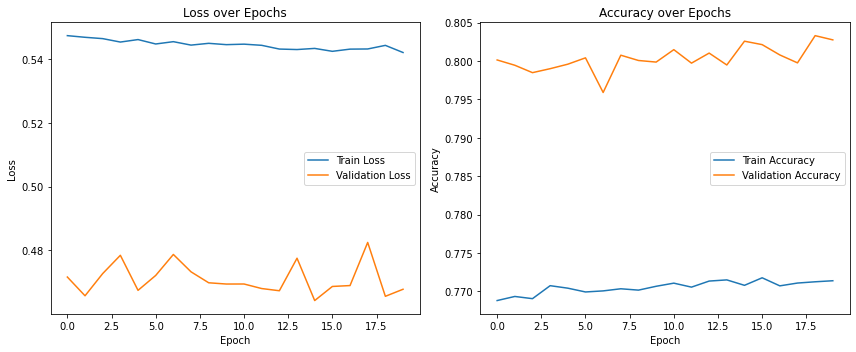

In [40]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [41]:
test_loss, test_accuracy = validate(model, test_loader, criterion, device)
print(f"\n Test Accuracy: {test_accuracy * 100:.2f}%")


 Test Accuracy: 80.07%


In [42]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        outputs = model(X_batch)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())


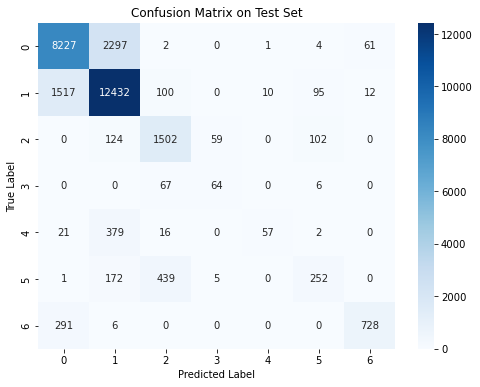

In [43]:
cm = confusion_matrix(all_labels, all_preds)
classes = np.unique(all_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix on Test Set')
plt.show()


In [ ]:
print("\n📋 Classification Report:\n")
print(classification_report(all_labels, all_preds, digits=4))


📋 Classification Report:

              precision    recall  f1-score   support

           0     0.8180    0.7767    0.7968     10592
           1     0.8067    0.8776    0.8407     14166
           2     0.7065    0.8405    0.7677      1787
           3     0.5000    0.4672    0.4830       137
           4     0.8382    0.1200    0.2099       475
           5     0.5466    0.2900    0.3789       869
           6     0.9089    0.7102    0.7974      1025

    accuracy                         0.8007     29051
   macro avg     0.7321    0.5832    0.6106     29051
weighted avg     0.7996    0.8007    0.7929     29051

